In [1]:
"""
Title: Suspicious Transaction Detection

Team: 4-member school course project (Chang Hi Lee, Edward (Yu Sung) Kang, Frank Moon, Won Young Kang)

Function: A fradulent card transaction prediction algorithm using the GradientBoostingClassifier method in conjunction with K-best feature selection. Plots PCA analysis and AUROC curve.

Preprocessing: Label encoding for categorical/boolean features and standardization of Gaussian features. Null values are replaced with mean values for Gaussian features. Timestamps only include hour of day.

Metric: Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

Description: Some payment service company wants to set up a fraud prevention system to detect suspicious transactions. Thus their customers' property will be better protected. 
Alert will be set to them and require confirmation when it seems that they are going to spend $40 for a 6-inch Subway. 
Reluctant to reveal their customer's privacy, they just offered some masked historical data with quite vague data description. 
Could you train a model and help predict the probability of Target is 1 (the transaction should be suspended)?
"""

"\nTitle: Suspicious Transaction Detection\n\nTeam: 4-member school course project (Chang Hi Lee, Edward (Yu Sung) Kang, Frank Moon, Won Young Kang)\n\nFunction: A fradulent card transaction prediction algorithm using the GradientBoostingClassifier method in conjunction with K-best feature selection. Plots PCA analysis and AUROC curve.\n\nPreprocessing: Label encoding for categorical/boolean features and standardization of Gaussian features. Null values are replaced with mean values for Gaussian features. Timestamps only include hour of day.\n\nMetric: Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.\n\nDescription: Some payment service company wants to set up a fraud prevention system to detect suspicious transactions. Thus their customers' property will be better protected. \nAlert will be set to them and require confirmation when it seems that they are going to spend $40 for a 6-inch Subway. \nReluctant to reveal their 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.options.mode.chained_assignment = None
# This silences the "settingwithcopy" warnings during data preprocessing.
# This warning occurs because we are modifying a Pandas Dataframe copy without specifying what to do with the original Dataframe.
# Since we are only concerned with the newest copy, it is acceptable to discard the original Dataframe and disregard this warning.
# The warning occurrence locations have been marked throughout the code for reference.

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Read the Data
train = pd.read_csv('../input/suspicious-transaction-detection/train.csv')
test = pd.read_csv('../input/suspicious-transaction-detection/test.csv')

# Create labels for training
train_y = train.Target

# Create training data
feature_cols = list(train.columns)
feature_cols = [e for e in feature_cols if e not in ('Target', 'TransactionID')]
train_X = train[feature_cols]
test_X = test[feature_cols]

/kaggle/input/suspicious-transaction-detection/sampleSubmission.csv
/kaggle/input/suspicious-transaction-detection/train.csv
/kaggle/input/suspicious-transaction-detection/test.csv


In [3]:
# Preprocessing the data 
from sklearn.preprocessing import LabelEncoder

# Distinguish different types of columns
categorical_cols = [e for e in feature_cols if e in ('Goods', 'A_0', 'A_1', 'E_0', 'E_1', 'M_0', 'M_1',  'C_5', 'C_23', 'C_24', 'C_25', 'C_26', 'C_27', 'C_28', 'O_2', 'O_4', 'O_6', 'O_7', 'O_8', 'O_10', 'O_11', 'O_12', 'O_13', 'O_14', 'O_15', 'O_16', 'O_17', 'O_19', 'O_21', 'O_23', 'O_24', 'O_25', 'O_26', 'O_27', 'O_31', 'O_32', 'O_35', 'O_36', 'O_39')]
boolean_cols = [e for e in feature_cols if e in ('C_0', 'C_1', 'C_2', 'C_3', 'C_4', 'C_6', 'C_7', 'C_8', 'O_28', 'O_30')]
gaussian_cols = [e for e in feature_cols if e not in boolean_cols if e not in categorical_cols]

# Convert categorical/boolean columns into label 
train_X[categorical_cols] = train_X[categorical_cols].apply(LabelEncoder().fit_transform) #this
train_X[boolean_cols] = train_X[boolean_cols].apply(LabelEncoder().fit_transform)# and this causes one of the warnings
test_X[categorical_cols] = test_X[categorical_cols].apply(LabelEncoder().fit_transform) # this too
test_X[boolean_cols] = train_X[boolean_cols].apply(LabelEncoder().fit_transform) # this too

# Fill NA entries for Gaussian columns with their mean values
mean_values_tr = train_X[gaussian_cols].describe().loc['mean']
mean_values_te = test_X[gaussian_cols].describe().loc['mean']
train_X.fillna(value = mean_values_tr, inplace = True) # Silenced "settingwithcopy" warning
test_X.fillna(value = mean_values_te, inplace = True) # Silenced "settingwithcopy" warning

# Preprocess timestamp to only contain hour
train_X['Timestamp'] = train_X['Timestamp'].astype('datetime64[ns]').dt.hour # Silenced "settingwithcopy" warning
test_X['Timestamp'] = test_X['Timestamp'].astype('datetime64[ns]').dt.hour

In [4]:
# Standardize Gaussian data(no need for categorical, boolean values)
from sklearn.preprocessing import StandardScaler
train_X[gaussian_cols] = StandardScaler().fit_transform(train_X[gaussian_cols].values)
test_X[gaussian_cols] = StandardScaler().fit_transform(test_X[gaussian_cols])
#train_X

In [5]:
# Conduct PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
d = pca.fit_transform(train_X)
#print(pca.components_)
print(d.shape)

(472432, 3)


In [6]:
# Separate fraud and non-fraud datapoints
x = []
y = []
z = []

x_f = []
y_f = []
z_f = []
for i in range(len(train_y)):
    if train_y[i] == 0: #not fraud
        x.append(d[i][0])
        y.append(d[i][1]) 
        z.append(d[i][2]) 
    else: #fraud
        x_f.append(d[i][0])
        y_f.append(d[i][1])
        z_f.append(d[i][2])

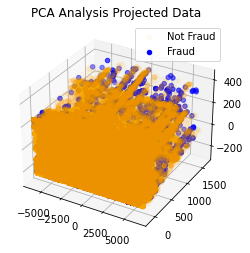

In [7]:
# Plot PCA projection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#print(len(train_X['Timestamp']))
#print(len(pca.components_[0]))
ax.scatter(x, y, z, 'o', label='Not Fraud', alpha = 0.05, color = 'orange')
ax.scatter(x_f, y_f, z_f, '^', label='Fraud', color = 'blue')
ax.set_title('PCA Analysis Projected Data')
ax.legend()

In [8]:
# Feature selection 
from sklearn.feature_selection import SelectKBest, f_classif
selected_k_features = SelectKBest(f_classif, k = 400) # choose how many to keep
new_train_X = selected_k_features.fit_transform(train_X, train_y)
mask = selected_k_features.get_support()
selected_columns = train_X.columns[mask]

# select features 
new_train_X = pd.DataFrame(new_train_X, columns=selected_columns)
new_test_X = test_X[selected_columns]

print(new_train_X.head)


<bound method NDFrame.head of         Timestamp    Amount  Goods       T_0       T_1           T_2  \
0       -1.655395 -0.318816    0.0 -1.088279 -0.408660 -7.156828e-01   
1       -0.785899 -0.364853    0.0 -1.290637 -0.573707  2.640262e-01   
2        0.083597 -0.467824    2.0  0.000000 -0.599098 -8.762909e-01   
3       -0.206235  0.062958    4.0  0.000000 -0.599098 -3.043170e-16   
4       -0.206235 -0.073990    0.0 -0.317760  0.219786 -1.803227e-01   
...           ...       ...    ...       ...       ...           ...   
472427   0.083597 -0.397957    0.0  0.834127  1.159282  6.066567e-01   
472428   0.663261 -0.432641    0.0  1.090966  1.368764  1.714852e+00   
472429   1.242925 -0.112125    0.0  0.141438  0.594315  1.077774e+00   
472430  -1.655395 -0.435760    0.0 -0.481203  0.086479  1.240697e-02   
472431  -1.075731  2.354768    0.0  0.000000 -0.599098 -3.043170e-16   

                 T_3           T_4      T_5           T_6  ...   O_36  \
0      -1.601190e-16  3.451098e-

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
# Choose model and train 
reg = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.2, max_depth = 1, random_state = 0).fit(new_train_X, train_y)

# Estimate in sample classification error
prob = reg.predict_proba(new_train_X)[:,1]
prediction_train = np.where(prob > 0.5, 1, 0)
difference = prediction_train - train_y 
result = np.where(difference == 0, 1, 0)
accuracy = float(result.sum()) / float(result.size)
print("In sample accuracy: ", accuracy )

In sample accuracy:  0.9717715988756054


In [10]:
# Make predictions and create submission file 
prediction = reg.predict_proba(new_test_X)[:,1] # choose p(y=1) and discard p(y=0)
my_submission = pd.DataFrame({'TransactionID': test.TransactionID, 'Target':prediction})
my_submission.to_csv('submission.csv', index=False)

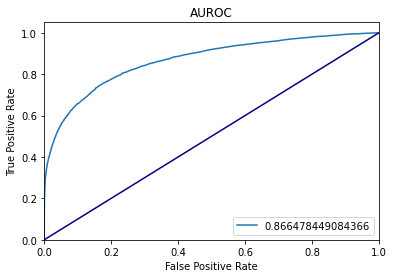

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_prob = reg.predict_proba(new_train_X)
y_score = reg.decision_function(new_train_X)

roc_auc = dict()
fpr, tpr, _ = roc_curve(train_y, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=roc_auc)
plt.plot([0, 1], [0, 1], color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC')
plt.legend(loc="lower right")
plt.show()